At first we import all the needed libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

After that we import the data and define the the features X and the target value y. 
We also split the data in test and train-data for the . After that we split the train data into the final train-data and the validation part.

In [2]:
# Importing the data
dataset = pd.read_excel('/Users/mustafa/Documents/GitHub/ML_knife_QA/data/chiefs_knife_dataset.xlsx')

# Features and target value 
X = dataset.loc[:, 'Original_Linienanzahl':'DFT_Median_sobel_Bereich'].values
y = dataset['Ra'].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Now data augmentation is used to get more values out of the given data. 

In [3]:
# Data Augmentation durch Rauschzugabe
noise = np.random.normal(0, 0.01, X_train.shape)  # Rauschen mit Mittelwert 0 und Standardabweichung 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels bleiben gleich

# Verknüpfung von Original- und Augmented Features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

Now the features get scaled because there are some features with very low values and some with very high values. After the scaling the features are in the same range.

In [4]:
# Feature-Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Now the raw model is trained with the RandomForestRegressor and the validation and test part are predicted. To analyze the model the mse and r2 score are printed. 

In [5]:
# Modelltraining mit RandomForestRegressor (Vor Randomized Search)
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred = regressor.predict(X_test_scaled)
y_val_pred = regressor.predict(X_val_scaled)

# Validation - Evaluierung
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print(f'Mean Squared Error (Validation): {mse_val}')
print(f'R^2 Score (Validation): {r2_val}\n')

# Evaluierung
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse}')
print(f'R^2 Score (Test): {r2}\n')

Mean Squared Error (Validation): 0.0012528578707782674
R^2 Score (Validation): 0.7186232639399773
Mean Squared Error (Test): 0.001264389265569918
R^2 Score (Test): 0.7307749999500167


To optimize the model a hyperparameter tuning is used. The method is the randomized search.
After the best model is found the tuned hyperparameters are printed and the new model is fitted with the train data.

In [ ]:
# Hyperparameter-Raster für Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Randomized Search für Random Forest Regressor
random_search_regressor = RandomizedSearchCV(estimator=regressor,
                                             param_distributions=param_grid, 
                                             n_iter=100, # Anzahl der zufälligen Kombinationen
                                             cv=5,       # Cross-Validation-Folds
                                             # scoring='neg_mean_squared_error', # Metrik für Regression
                                             scoring='r2',
                                             n_jobs=-1,  # Alle verfügbaren Kerne verwenden
                                             verbose=0,  # Ausführlichkeit
                                             random_state=42)  # Für Reproduzierbarkeit

# Ausgabe der besten Hyperparameter
print(f'Beste Hyperparameter für Regressor: {random_search_regressor.best_params_}\n')

# Fitting the model with the optimized hyperparamaters
random_search_regressor.fit(X_train_scaled, y_train)

# Bestes Modell basierend auf der Suche
best_model = random_search_regressor.best_estimator_

Now the values get predicted with the best model and is also evaluated with the mse and r2 score.

Mean Squared Error (Validation): 0.0012638767841409693
R^2 Score (Validation): 0.7161485491704567
Mean Squared Error (Test): 0.0012722912338425385
R^2 Score (Test): 0.7290924426343848
Beste Hyperparameter für Regressor: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best Model Mean Squared Error: 0.0013060157253820313
Best Model R^2 Score: 0.7219115241596354


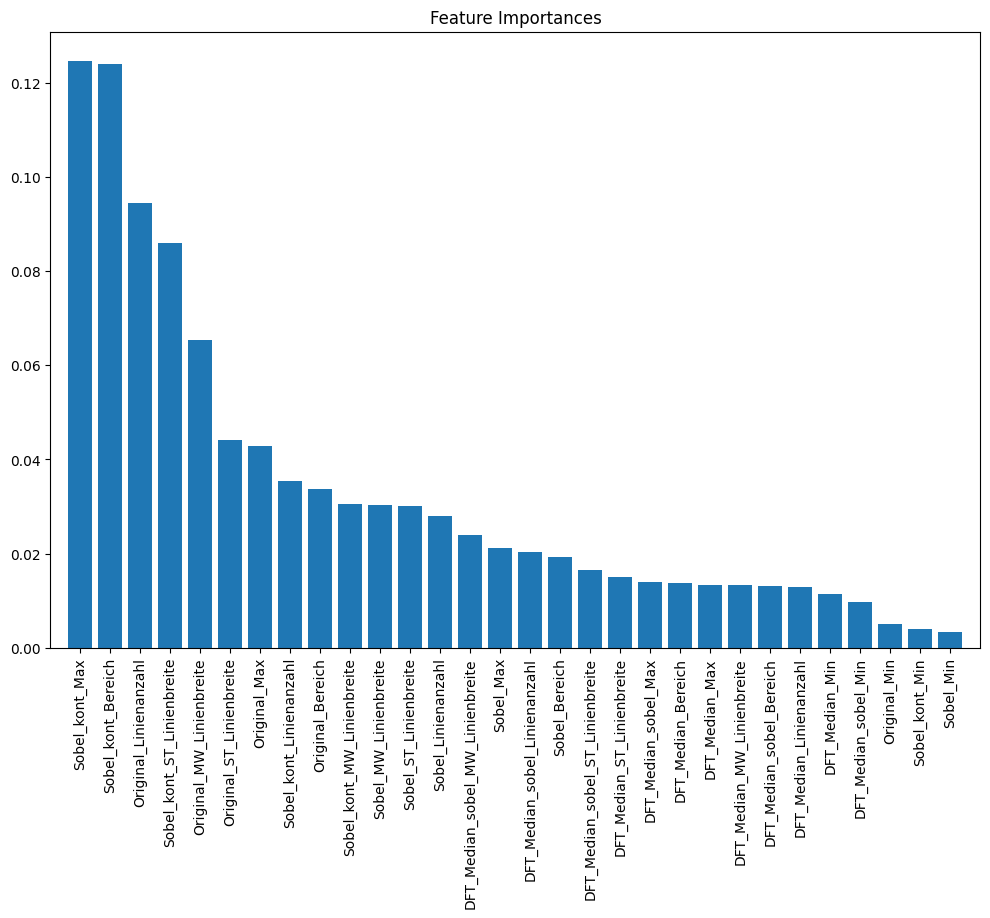

                             Feature  Importance
0                     Sobel_kont_Max    0.124638
1                 Sobel_kont_Bereich    0.123937
2              Original_Linienanzahl    0.094494
3         Sobel_kont_ST_Linienbreite    0.086044
4           Original_MW_Linienbreite    0.065392
5           Original_ST_Linienbreite    0.044096
6                       Original_Max    0.042913
7            Sobel_kont_Linienanzahl    0.035526
8                   Original_Bereich    0.033832
9         Sobel_kont_MW_Linienbreite    0.030442
10             Sobel_MW_Linienbreite    0.030398
11             Sobel_ST_Linienbreite    0.030047
12                Sobel_Linienanzahl    0.027932
13  DFT_Median_sobel_MW_Linienbreite    0.023917
14                         Sobel_Max    0.021185
15     DFT_Median_sobel_Linienanzahl    0.020349
16                     Sobel_Bereich    0.019336
17  DFT_Median_sobel_ST_Linienbreite    0.016462
18        DFT_Median_ST_Linienbreite    0.014954
19              DFT_

In [3]:
# Vorhersagen mit dem besten Modell
y_pred_best = best_model.predict(X_test_scaled)
y_val_pred_best = best_model.predict(X_val_scaled)

# Validation - Evaluierung
mse_val_best = mean_squared_error(y_val, y_val_pred_best)
r2_val_best = r2_score(y_val, y_val_pred_best)
print(f'Best Model Mean Squared Error (Validation): {mse_val_best}')
print(f'Best Model R^2 Score (Validation): {r2_val_best}\n')

# Evaluierung des besten Modells
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model R^2 Score: {r2_best}\n')

Another method for possible optimization are the feature importances. They are calculated and are printed in a graph and a list.

In [ ]:
# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Namen der Features
feature1 = dataset.columns.get_loc('Original_Linienanzahl')
feature2 = dataset.columns.get_loc('DFT_Median_sobel_Bereich')
feature_names = dataset.columns[feature1:feature2+1]

# Visualisierung der Feature Importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
plt.savefig('feature_importances_regressor.png', dpi=300)

# Ausgabe der Feature Importances
feature_importances = pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
print(feature_importances)

In this function a treshold can be chosen and all the features with lower importances are dropped automatically.

In [ ]:
def select_relevant_features(threshold):
    # Filtern der Features mit Importance < treshold
    important_features = feature_importances[feature_importances['Importance'] >= threshold]

    # Liste der zu behaltenden Features
    features_to_keep = important_features['Feature'].values

    # Auswahl der entsprechenden Spalten aus dem ursprünglichen DataFrame
    X_important = dataset[features_to_keep]
    return X_important

threshold = 0.01
X_important = select_relevant_features(threshold)

Complete new train-test split, data augmentation, model training and prediction.

In [ ]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data Augmentation durch Rauschzugabe
noise = np.random.normal(0, 0.01, X_train.shape)  # Rauschen mit Mittelwert 0 und Standardabweichung 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels bleiben gleich

# Verknüpfung von Original- und Augmented Features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

# Feature-Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# Modelltraining mit RandomForestRegressor (after dropping features with low importance)
regressor_dropped = RandomForestRegressor(random_state=42)
regressor_dropped.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred = regressor_dropped.predict(X_test_scaled)
y_val_pred = regressor_dropped.predict(X_val_scaled)

# Validation - Evaluierung
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print(f'\nMean Squared Error (Validation): {mse_val}')
print(f'R^2 Score (Validation): {r2_val}\n')

# Evaluierung
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse}')
print(f'R^2 Score (Test): {r2}\n')

Now the Error of the prediction is printed in two graphs. The first one shows the predicted and observed values of Ra and shows the calculated error between them. 

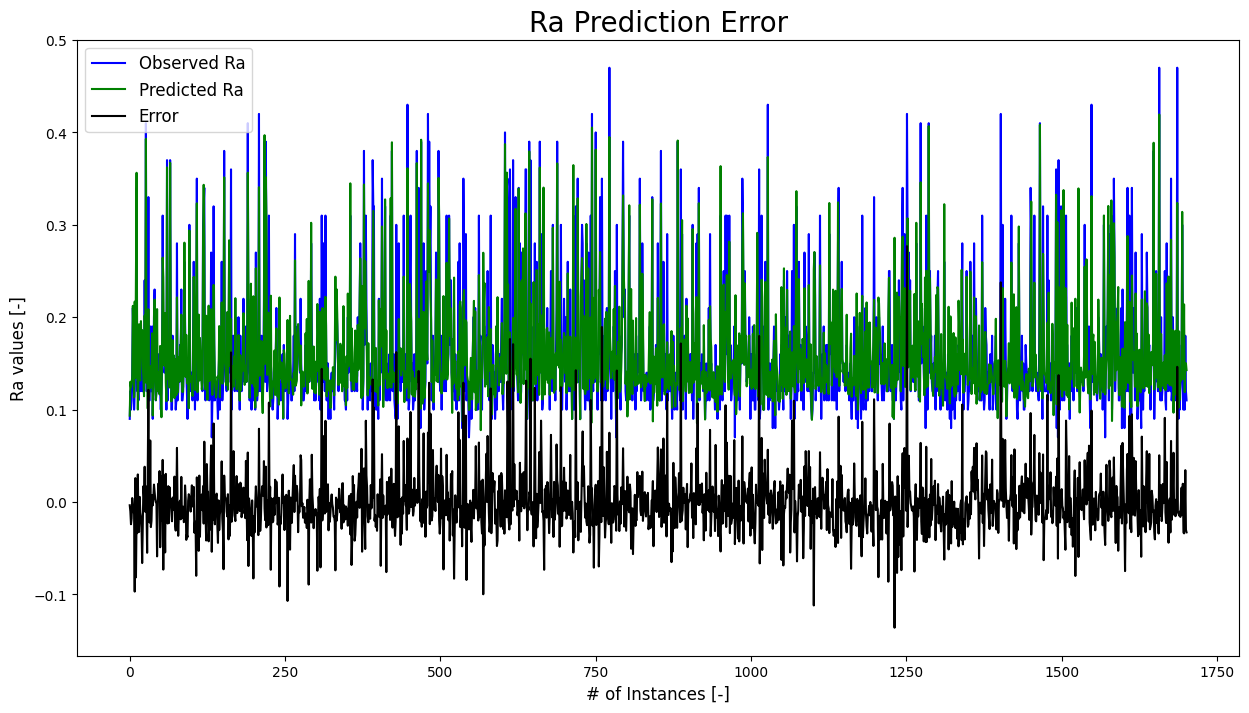

In [5]:
# Error of prediction
error_pred = y_test-y_pred

# Plot of the prediction error
plt.figure(figsize=(15, 8))
plt.plot(range(0,len(y_test)), y_test, '-b', label="Observed Ra")
plt.plot(range(0,len(y_pred)), y_pred, '-g', label="Predicted Ra")
plt.plot(range(0,len(y_pred)), error_pred, '-k', label="Error")
plt.title('Ra Prediction Error', fontsize=20)
plt.xlabel('# of Instances [-]', fontsize=12)
plt.ylabel('Ra values [-]', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('regressor_error.png', dpi=300)

The second graph shows the overlapped observed and predicted values for Ra

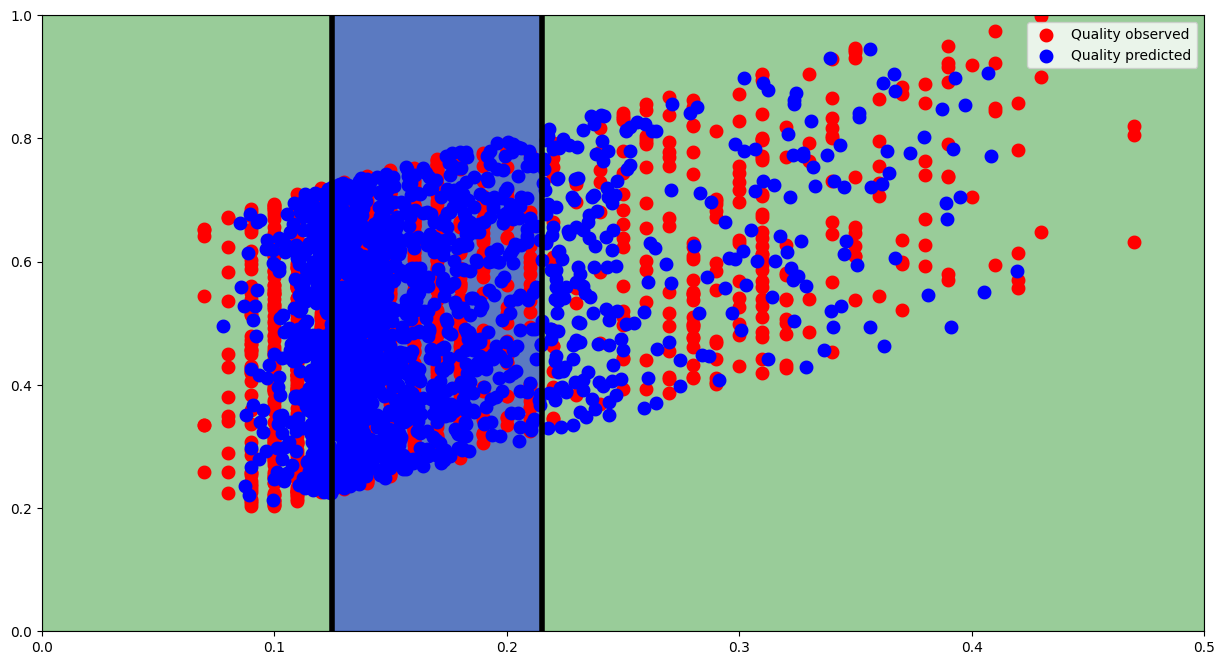

In [7]:
# Spezifikationsgrenzen
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215

# Plot of the predicted values and the observed values 
plt.figure(figsize=(15,8))
plt.axvline(LOWER_SPECIFICATION_LIMIT,color='black', linewidth=4)
plt.axvline(UPPER_SPECIFICATION_LIMIT,color='black',linewidth=4)
plt.fill_betweenx([0, 1], 0, 0.5, color='green', alpha=0.4) 
plt.fill_betweenx([0, 1], LOWER_SPECIFICATION_LIMIT, UPPER_SPECIFICATION_LIMIT, color='blue', alpha=0.4)
plt.scatter(y_test,y_test + np.random.uniform(0.10,0.6, size=y_test.shape),color='red',linewidth=4, label='Quality observed')
plt.scatter(y_pred,y_pred + np.random.uniform(0.10,0.6, size=y_pred.shape), color='blue',linewidth=4,label='Quality predicted')
plt.legend()
plt.xlim([0,0.5])
plt.ylim([0,1])
plt.savefig(f'regressor_region_insights.png', dpi=300)